In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import itertools

In [2]:
train_gen = ImageDataGenerator(
    fill_mode='nearest',
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.4, 1.4],
    zoom_range=[0.9, 1.1],
    horizontal_flip=True,
    rescale=1./255,
    validation_split=0.15,)

test_gen = ImageDataGenerator(rescale=1./255)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
train_generator = train_gen.flow_from_directory(
    '/content/drive/MyDrive/Dataset for Train test/train',
    target_size=(128,128),
    batch_size=4,
    color_mode='rgb',
    class_mode='categorical',
    subset='training',
)

val_generator = train_gen.flow_from_directory(
    '/content/drive/MyDrive/Dataset for Train test/train',
    target_size=(128,128),
    batch_size=4,
    color_mode='rgb',
    class_mode='categorical',
    subset='validation',
)

Found 1052 images belonging to 2 classes.
Found 184 images belonging to 2 classes.


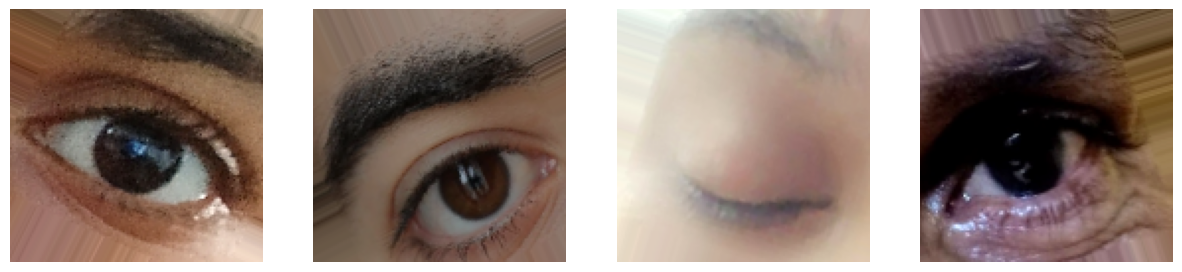

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,15))

for i in range(4):

  image = next(train_generator)[0].astype('float16')

  image = np.squeeze(image)

  ax[i].imshow(image[0].astype('float32'))
  ax[i].axis('off')

In [8]:
resnet_model = tf.keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet', classes = 2, input_shape = (128,128,3))
resnet_model.trainable = True
resnet_model.summary()

94765736/94765736 [==============================] - 4s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalizat

In [9]:
train_generator.class_indices

{'Closed': 0, 'Open': 1}

In [10]:
# set_trainable=False

# for layer in resnet_model.layers:
#     if layer.name=='conv4_block1_1_conv':
#         set_trainable=True
#     layer.trainable=set_trainable

In [11]:
# for layer in resnet_model.layers:
#     print(layer.name, layer.trainable)

In [12]:
model=Sequential([
    resnet_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dense(128, activation='relu'),
    Dense(2, activation='softmax')])

In [13]:
model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 512)               16777728  
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 2)                 258       
                                                                 
Total params: 40,431,362
Trainable params: 40,378,242
Non-trainable params: 53,120
_________________________________________________________________


In [16]:
history = model.fit(
    train_generator,
    epochs=50,
    shuffle=True,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
)

Epoch 1/50
263/263 [==============================] - 69s 264ms/step - loss: 0.1056 - accuracy: 0.9838 - val_loss: 1.4337 - val_accuracy: 0.5761
Epoch 2/50
263/263 [==============================] - 19s 73ms/step - loss: 0.0920 - accuracy: 0.9914 - val_loss: 0.3744 - val_accuracy: 0.8750
Epoch 3/50
263/263 [==============================] - 22s 84ms/step - loss: 0.0387 - accuracy: 0.9857 - val_loss: 0.1250 - val_accuracy: 0.9565
Epoch 4/50
263/263 [==============================] - 23s 86ms/step - loss: 0.0242 - accuracy: 0.9981 - val_loss: 0.0601 - val_accuracy: 0.9837
Epoch 5/50
263/263 [==============================] - 21s 78ms/step - loss: 0.0083 - accuracy: 0.9981 - val_loss: 0.1043 - val_accuracy: 0.9891
Epoch 6/50
263/263 [==============================] - 20s 75ms/step - loss: 0.0175 - accuracy: 0.9924 - val_loss: 0.4753 - val_accuracy: 0.9348
Epoch 7/50
263/263 [==============================] - 23s 87ms/step - loss: 0.0435 - accuracy: 0.9952 - val_loss: 0.6493 - val_accuracy

In [19]:
test_generator = test_gen.flow_from_directory(
    '/content/drive/MyDrive/Dataset for Train test/test',
    target_size=(128,128),
    batch_size=4,
    color_mode='rgb',
    class_mode='categorical',
)

Found 218 images belonging to 2 classes.


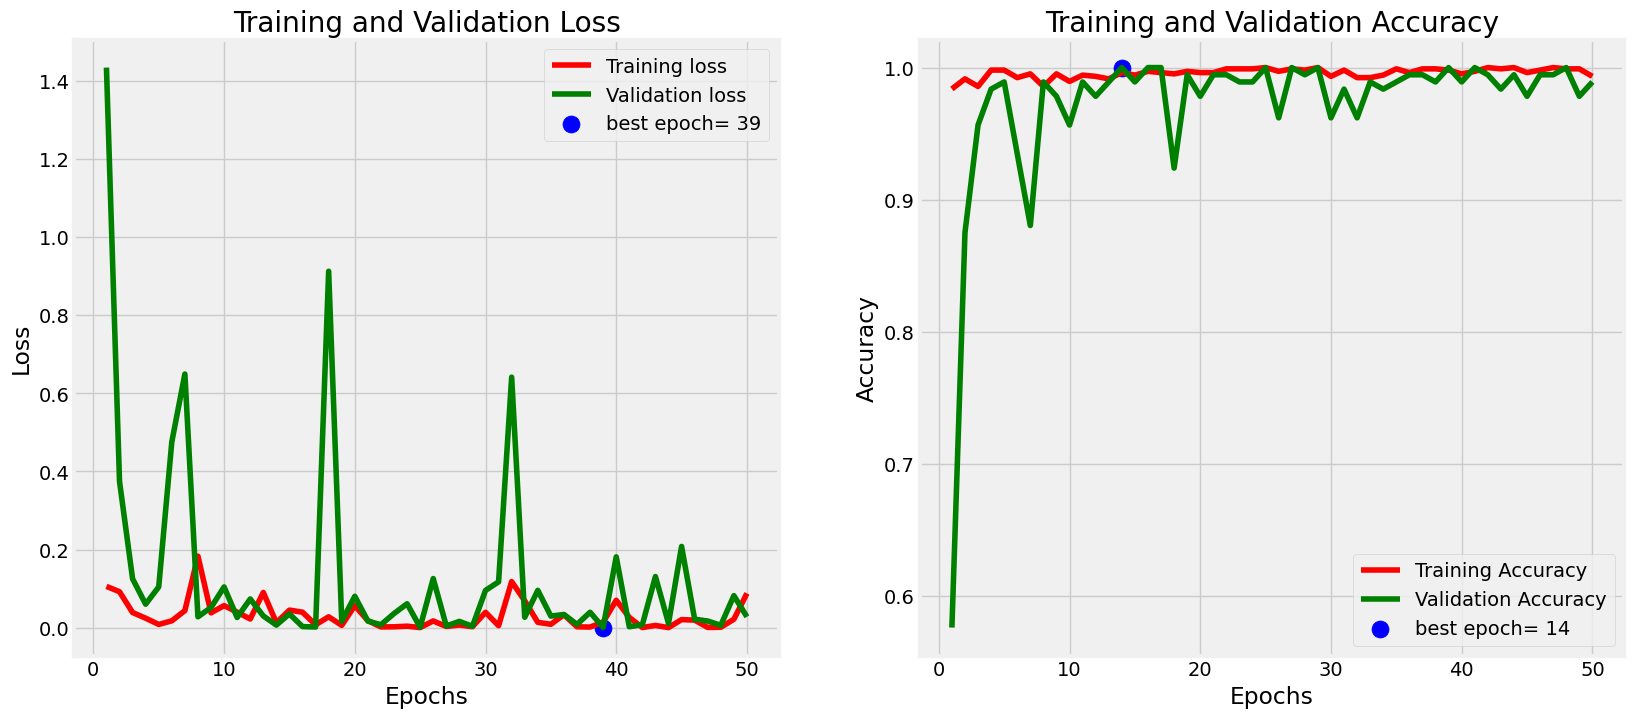

In [20]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [21]:
ts_length = len(test_generator)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_generator, steps= test_steps, verbose= 1)
valid_score = model.evaluate(val_generator, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_generator, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

1/1 [==============================] - 0s 89ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Train Loss:  0.03565673157572746
Train Accuracy:  1.0
--------------------
Validation Loss:  0.0
Validation Accuracy:  1.0
--------------------
Test Loss:  0.0
Test Accuracy:  1.0


In [22]:
pred = model.predict(test_generator)
y_pred = np.argmax(pred,axis = 1)

55/55 [==============================] - 42s 761ms/step


In [23]:
g_dict = test_generator.class_indices
classes = list(g_dict.keys())
classes

['Closed', 'Open']

In [24]:
# print(y_pred)
# print(pred)

In [40]:
i = 0
k = 0
for thing in test_generator:
  pred = model.predict(thing[0])
  # print(pred)
  np_pred = np.argmax(pred, axis = 1)
  if((np_pred == np.argmax(thing[1], axis = 1)).all()):
    i+=1
  k+=1
  if k==55 :
    break

print(i/len(test_generator))

1/1 [==============================] - 0s 32ms/step
1.0


In [41]:
model.evaluate(test_generator)

55/55 [==============================] - 2s 25ms/step - loss: 2.7253e-04 - accuracy: 1.0000


[0.00027253178996033967, 1.0]